In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from botorch import acquisition
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch import fit_fully_bayesian_model_nuts

from gpytorch.constraints import GreaterThan

from botorch.models import SingleTaskGP, ModelListGP, MultiTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import Branin
from torch.quasirandom import SobolEngine


%matplotlib inline
SMOKE_TEST = os.environ.get("SMOKE_TEST")

c:\Users\MajidMortazavi\Git\BayesianOptimization_PracticalExamples\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tkwargs = {"device": torch.device("cuda" if torch.cuda.is_available() else "cpu"), "dtype": torch.double}


### Objective Function & Data


C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_3116\1747820532.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


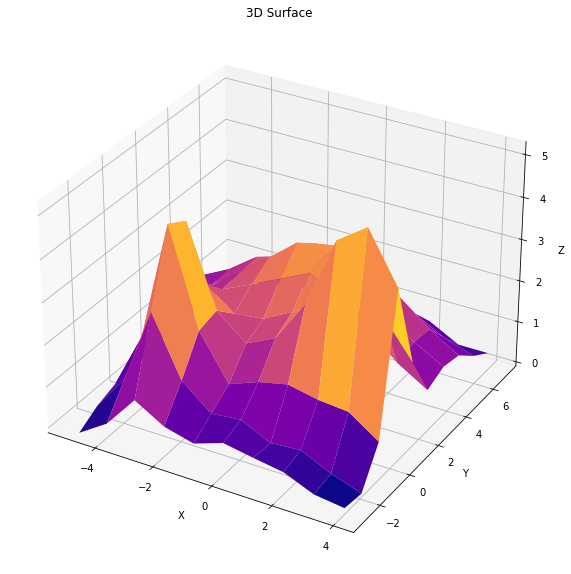

In [3]:
from mpl_toolkits.mplot3d import Axes3D


def generate_3d_data(xmin, xmax, ymin, ymax, line_mesh):

    # The two-dimensional domain of the fit.
    xmin, xmax, nx = xmin, xmax, line_mesh
    ymin, ymax, ny = ymin, ymax, line_mesh
    x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y)

    # Our function to fit is going to be a sum of two-dimensional Gaussians
    def gaussian(x, y, x0, y0, xalpha, yalpha, A):
        return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

    # A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
    gprms = [(0, 2, 2.5, 5.4, 1.5),
            (-1, 4, 6, 2.5, 1.8),
            (-3, -0.5, 1, 2, 4),
            (3, 0.5, 2, 1, 5)
            ]

    # Standard deviation of normally-distributed noise to add in generating
    # our test function to fit.
    noise_sigma = 0.1

    # The function to be fit is Z.
    Z = np.zeros(X.shape)
    for p in gprms:
        Z += gaussian(X, Y, *p)
    Z += noise_sigma * np.random.randn(*Z.shape)

    return X, Y, Z

X, Y, Z = generate_3d_data(-5, 4, -3, 7, 10)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface')
plt.show();

In [72]:
xmin, xmax, ymin, ymax = -5, 4, -3, 7
X, Y, Y = generate_3d_data(xmin, xmax, ymin, ymax, 10)
df = pd.DataFrame(columns=['X','Y','Z'], dtype=float)

df['X'] = X.reshape(-1, ).astype(float)
df['Y'] = Y.reshape(-1, ).astype(float)
df['Z'] = Z.reshape(-1, ).astype(float)


train_X , test_X, train_Y, test_Y  = train_test_split(df[['X', "Y"]].values, df[['Z']].values, test_size=0.2)

train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_Y = torch.tensor(train_Y)
test_Y = torch.tensor(test_Y)

### High-Dimensional sample-efficient Bayesian Optimization

In [73]:
def gen_next_point(init_x, init_y, best_init_y, bounds, n_points=1):
    
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """

    model = SingleTaskGP(init_x, init_y)
    model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_model(mll)

    acquisition_func = acquisition.ExpectedImprovement(model=model, best_f= best_init_y)
    # acquisition_func = qExpectedImprovement(model=model, best_f= best_init_y)

    candidates, _ = optimize_acqf(acq_function=acquisition_func,
                                    bounds=bounds,
                                    q=n_points,
                                    num_restarts=200,
                                    raw_samples=512,
                                    options={'batch_limit': 5, 'maxiter': 100})
    
    print(f"The next point to be evaluated is {candidates}")

    return candidates



In [74]:
def gen_next_point_new(best_init_y, bounds, n_points=1):
    
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """


    acquisition_func = acquisition.ExpectedImprovement(model=model, best_f= best_init_y)
    # acquisition_func = qExpectedImprovement(model=model, best_f= best_init_y)

    candidates, _ = optimize_acqf(acq_function=acquisition_func,
                                    bounds=bounds,
                                    q=n_points,
                                    num_restarts=200,
                                    raw_samples=512,
                                    options={'batch_limit': 5, 'maxiter': 100})
    
    print(f"The next point to be evaluated is {candidates}")

    return candidates



In [75]:
model = SingleTaskGP(train_X, train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [81]:
bounds = torch.tensor([[-5., -3.0], [4., 7.0]])


new_train_X = gen_next_point_new(0, bounds)
new_train_Y = model.posterior(new_train_X).mean

The next point to be evaluated is tensor([[2.1888, 4.7812]])


In [82]:
train_X = torch.cat([train_X, new_train_X])
train_Y = torch.cat([train_Y, new_train_Y])

In [83]:
train_Y.mean()

tensor(1.6519, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [84]:
new_train_X = gen_next_point_new(train_Y.mean(), bounds)


The next point to be evaluated is tensor([[2.1888, 4.7812]])


In [86]:
model = SingleTaskGP(new_train_X, new_train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
fit_gpytorch_model(mll)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
n_runs = 20

train_X , test_X, train_Y, test_Y  = train_test_split(df[['X', "Y"]].values, df[['Z']].values, test_size=0.2)

train_X = torch.tensor(train_X)
test_X = torch.tensor(test_X)
train_Y = torch.tensor(train_Y)
test_Y = torch.tensor(test_Y)

# Dense grid of points within bounds
bounds = torch.tensor([[-5., -3.0], [4., 7.0]])

for i in range(n_runs):
    print(f"Nr. of Optimal Run: {i}")
    new_train_X = gen_next_point(train_X, train_Y, 0, bounds)
    new_train_Y = model.posterior(new_train_X)
    
    train_X = torch.cat([train_X, new_train_X])
    train_Y = torch.cat([train_Y, new_train_Y.mean])


Nr. of Optimal Run: 0
The next point to be evaluated is tensor([[3.0431, 5.2478]])
Nr. of Optimal Run: 1


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
gp = SaasFullyBayesianSingleTaskGP(train_X=train_X, train_Y=train_Y)
fit_fully_bayesian_model_nuts(
    gp, warmup_steps=WARMUP_STEPS, num_samples=NUM_SAMPLES, thinning=THINNING, disable_progbar=True
)

In [ ]:

with torch.no_grad():
    posterior = gp.posterior(test_X)

### Make predictions with the model

In [ ]:
print(f"Ground truth:     {test_Y.squeeze(-1)}")
print(f"Mixture mean:     {posterior.mixture_mean.squeeze(-1)}")
print(f"Mixture median:   {posterior.mixture_median.squeeze(-1)}")

### Optimize  Explore Next Test Point

In [ ]:
init_x = torch.tensor(x)
init_y = torch.tensor(y).unsqueeze(-1)

model = SingleTaskGP(init_x, init_y)
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
fit_gpytorch_model(mll)

KeyboardInterrupt: 

In [ ]:
EI = qExpectedImprovement(model=model, best_f= 0)

bounds = torch.tensor([[-5., -3.0], [4., 7.0]])

candidates, _ = optimize_acqf(acq_function=EI,
                                bounds=bounds,
                                q=1,
                                num_restarts=200,
                                raw_samples=512,
                                options={'batch_limit': 5, 'maxiter': 100})

UnsupportedError: Must specify an objective or a posterior transform when using a multi-output model.

In [ ]:
    plt.plot(bo.max["params"]["X"],bo.max["params"]["Y"], '*', markersize=10)
    plt.show()
    
    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)
    next_point_to_probe = bo.suggest(utility)


    print(f"Next Point to Probe: {next_point_to_probe}")
    print(f"Optimal Point: {bo.max}")

UnsupportedError: Must specify a posterior transform when using a multi-output model.

In [ ]:

bounds = torch.tensor([[-5., -3.0], [4., 7.0]])

candidates, _ = optimize_acqf(acq_function=EI,
                                bounds=bounds,
                                q=1,
                                num_restarts=200,
                                raw_samples=512,
                                options={'batch_limit': 5, 'maxiter': 100})

### Next Experiment

In [ ]:
def gen_next_point(X, Y, Z, best_init_y, bounds, n_points=1):
    
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """
    init_x = torch.tensor([X, Y])
    init_y = torch.tensor([Z])

    model = SingleTaskGP(init_x, init_y)
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_model(mll)

    EI = qExpectedImprovement(model=model, best_f= best_init_y)

    candidates, _ = optimize_acqf(acq_function=EI,
                                    bounds=bounds,
                                    q=n_points,
                                    num_restarts=200,
                                    raw_samples=512,
                                    options={'batch_limit': 5, 'maxiter': 100})
    
    print(f"The next point to be evaluated is {candidates}")

    return candidates


bounds = torch.tensor([[-5., -3.0], [4., 7.0]])
gen_next_point(X1, X2, Y, 0, bounds)

UnsupportedError: Must specify an objective or a posterior transform when using a multi-output model.

### Gaussian processes & Optimizing using expected improvement

In [ ]:
n_runs = 10

# Dense grid of points within bounds
init_x, init_y, best_observed_y = generate_initial_data(-2, 3, 10, 0)
bounds = torch.tensor([[-2.], [3.]])

for i in range(n_runs):
    print(f"Nr. of Optimal Run: {i}")
    new_candidates = gen_next_point(init_x, init_y, best_observed_y, bounds, 1)
    new_results = target_function(new_candidates, 0).unsqueeze(-1)
    print(f"The new candidate are: {new_candidates}")

    init_x = torch.cat([init_x, new_candidates])
    init_y = torch.cat([init_y, new_results])

    best_observed_y = init_y.max().item()
    print(f"The best observed value is: {best_observed_y}")

C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_24912\987756712.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


Nr. of Optimal Run: 0
The next point to be evaluated is tensor([[-0.4075]])
The new candidate are: tensor([[-0.4075]])
The best observed value is: 0.49702654036345206
Nr. of Optimal Run: 1
The next point to be evaluated is tensor([[-0.3426]])
The new candidate are: tensor([[-0.3426]])
The best observed value is: 0.49896305799484253
Nr. of Optimal Run: 2
The next point to be evaluated is tensor([[-0.3623]])
The new candidate are: tensor([[-0.3623]])
The best observed value is: 0.5003179311752319
Nr. of Optimal Run: 3
The next point to be evaluated is tensor([[-0.3620]])
The new candidate are: tensor([[-0.3620]])
The best observed value is: 0.5003265142440796
Nr. of Optimal Run: 4
The next point to be evaluated is tensor([[-0.3615]])
The new candidate are: tensor([[-0.3615]])
The best observed value is: 0.500338077545166
Nr. of Optimal Run: 5
The next point to be evaluated is tensor([[-0.3612]])
The new candidate are: tensor([[-0.3612]])
The best observed value is: 0.5003437399864197
Nr.

### Compute posterior over test points and plot fit

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [ ]:
lower_bound = -2
upper_bound = 3
num_of_points = 10
noise = 0

train_X, train_Y, best_observed_y = generate_initial_data(lower_bound, upper_bound, num_of_points, noise)

model = SingleTaskGP(train_X, train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
fit_gpytorch_model(mll)

# set model (and likelihood)
model.eval()

C:\Users\MajidMortazavi\AppData\Local\Temp\ipykernel_24912\987756712.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y)


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

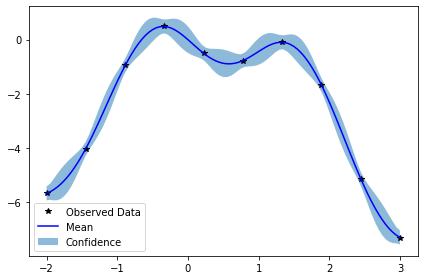

In [ ]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(lower_bound, upper_bound, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()